# Detección de Hernia Hiatal en RX Frontal

Este notebook implementa un pipeline de IA **simple, reproducible y explicable** para clasificar radiografías frontales en:
- `Normal`
- `Hernia hiatal`

## Etapas del proyecto de IA
1. **Configuración y versiones**: librerías, parámetros y dispositivo.
2. **Definición del pipeline**: dataset, transformaciones, modelo y métricas.
3. **Carga y entendimiento de datos**: distribución de clases y revisión visual.
4. **Entrenamiento y validación**: fine-tuning con early stopping.
5. **Evaluación clínica**: matriz de confusión, ROC, PR, sensibilidad y especificidad.
6. **Interpretabilidad**: Grad-CAM en casos TP/TN/FP/FN.
7. **Generalización opcional**: validación cruzada (CV) y OOF.
8. **Uso práctico**: inferencia sobre una imagen nueva.

## Modo opcional con anotaciones
El pipeline incluye un modo condicional para usar máscaras cuando estén listas:
- `USAR_ANOTACIONES = False` (modo actual sin máscaras)
- `USAR_ANOTACIONES = True` (usa máscaras para mejorar enfoque anatómico)

## Actualización recomendada de librerías
```bash
python3 -m pip install -U numpy scipy scikit-learn pandas matplotlib torch torchvision pillow
```



In [25]:
# Etapa 1) Configuración, versiones y parámetros
from pathlib import Path
from dataclasses import dataclass
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import densenet121, DenseNet121_Weights

from PIL import Image, ImageOps
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    accuracy_score,
    f1_score,
)

print('torch:', torch.__version__)
print('torchvision:', torchvision.__version__)
print('scikit-learn:', sklearn.__version__)
print('pandas:', pd.__version__)
print('numpy:', np.__version__)

RAIZ = Path.cwd().resolve()
if RAIZ.name == 'jupyter':
    RAIZ = RAIZ.parent

RUTA_IMAGENES = RAIZ / 'data' / 'images'
RUTA_CSV = RAIZ / 'data' / 'csv' / 'images_labels.csv'
RUTA_MASCARAS = RAIZ / 'data' / 'masks'
USAR_CSV = False

RUTA_SALIDA = RAIZ / 'outputs' / 'hiatal_notebook'
RUTA_SALIDA.mkdir(parents=True, exist_ok=True)

SEMILLA = 42
N_SPLITS = 5
TAM_IMAGEN = 320
TAM_BATCH = 8
EPOCAS = 20
EPOCAS_CONGELADAS = 3
PACIENCIA = 5
NUM_WORKERS = 0

USAR_ROI = True
USAR_PREENTRENADO = True
DROPOUT = 0.25
USAR_SAMPLER_BALANCEADO = True
USAR_FOCAL_LOSS = True
GAMMA_FOCAL = 2.0
USAR_TTA_FLIP_HORIZONTAL = True
OPTIMIZAR_UMBRAL = True
RUN_CV_COMPLETO = True

# Modo condicional de anotaciones (máscaras)
USAR_ANOTACIONES = False
MODO_ANOTACIONES = 'ponderar_fondo'   # 'ponderar_fondo' o 'recorte_mascara'
COLUMNA_MASCARA_CSV = 'mask_path'
ATENUACION_FONDO = 0.35
MARGEN_RECORTE_MASCARA = 0.15

DISPOSITIVO = torch.device('cuda') if torch.cuda.is_available() else (
    torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
)
USAR_AMP = DISPOSITIVO.type == 'cuda'

print('RAIZ:', RAIZ)
print('DISPOSITIVO:', DISPOSITIVO)
print('USAR_ANOTACIONES:', USAR_ANOTACIONES, '| MODO_ANOTACIONES:', MODO_ANOTACIONES)



torch: 2.9.0+cu126
torchvision: 0.24.0+cu126
scikit-learn: 1.7.2
pandas: 2.3.3
numpy: 2.2.6
RAIZ: G:\My Drive\Educacion\U de los Andes\MAIA\IV\Proyecto - Desarrollo de Soluciones\maia_proyecto_desarrollo_soluciones
DISPOSITIVO: cuda
USAR_ANOTACIONES: False | MODO_ANOTACIONES: ponderar_fondo


In [26]:
# Etapa 2) Utilidades del pipeline (datos, entrenamiento, métricas y Grad-CAM)
EXTENSIONES_VALIDAS = {'.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'}
ETIQUETAS_NORMAL = {'0', 'normal', 'sano', 'healthy', 'neg', 'negative'}
MEDIA_IMAGENET = [0.485, 0.456, 0.406]
STD_IMAGENET = [0.229, 0.224, 0.225]

# Fijar semilla para resultados reproducibles.
random.seed(SEMILLA)
np.random.seed(SEMILLA)
torch.manual_seed(SEMILLA)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEMILLA)


@dataclass(frozen=True)
class Muestra:
    # Representa una imagen con su etiqueta binaria e ID secuencial.
    ruta: Path
    etiqueta: int
    id_paciente: str
    ruta_mascara: Path | None = None


class RecorteRetrocardiaco:
    # Recorta una región central-inferior donde suele aparecer señal útil de hernia hiatal.
    def __init__(self, x1=0.2, x2=0.8, y1=0.15, y2=0.98):
        self.x1, self.x2, self.y1, self.y2 = x1, x2, y1, y2

    def __call__(self, imagen: Image.Image):
        ancho, alto = imagen.size
        return imagen.crop((int(self.x1 * ancho), int(self.y1 * alto), int(self.x2 * ancho), int(self.y2 * alto)))


class ConjuntoHiatal(Dataset):
    # Carga imágenes y aplica transformaciones para PyTorch.
    # Si hay máscaras y USAR_ANOTACIONES=True, aplica enfoque guiado por anotación.
    def __init__(self, muestras, indices, transformacion):
        self.muestras = [muestras[i] for i in indices]
        self.transformacion = transformacion

    def __len__(self):
        return len(self.muestras)

    def __getitem__(self, i):
        muestra = self.muestras[i]
        with Image.open(muestra.ruta) as imagen:
            imagen_rgb = imagen.convert('RGB')

        if USAR_ANOTACIONES and (muestra.ruta_mascara is not None):
            with Image.open(muestra.ruta_mascara) as img_mask:
                mask_pil = img_mask.convert('L').resize(imagen_rgb.size, resample=Image.Resampling.NEAREST)
            mask_np = (np.asarray(mask_pil, dtype=np.uint8) > 0).astype(np.float32)

            if MODO_ANOTACIONES == 'recorte_mascara':
                ys, xs = np.where(mask_np > 0)
                x1, x2 = xs.min(), xs.max()
                y1, y2 = ys.min(), ys.max()
                dx = int((x2 - x1 + 1) * MARGEN_RECORTE_MASCARA)
                dy = int((y2 - y1 + 1) * MARGEN_RECORTE_MASCARA)
                x1 = max(0, x1 - dx)
                y1 = max(0, y1 - dy)
                x2 = min(imagen_rgb.width - 1, x2 + dx)
                y2 = min(imagen_rgb.height - 1, y2 + dy)
                imagen_rgb = imagen_rgb.crop((x1, y1, x2 + 1, y2 + 1))
            else:
                img_np = np.asarray(imagen_rgb, dtype=np.float32) / 255.0
                peso = ATENUACION_FONDO + (1.0 - ATENUACION_FONDO) * mask_np[..., None]
                img_np = np.clip(img_np * peso, 0.0, 1.0)
                imagen_rgb = Image.fromarray((img_np * 255).astype(np.uint8))

        tensor_entrada = self.transformacion(imagen_rgb)
        objetivo = torch.tensor(float(muestra.etiqueta), dtype=torch.float32)
        return tensor_entrada, objetivo, str(muestra.ruta)


class PerdidaFocalBinariaConLogits(nn.Module):
    # Implementa Focal Loss binaria sobre logits para mejorar aprendizaje en casos difíciles.
    def __init__(self, gamma=2.0, pos_weight=None):
        super().__init__()
        self.gamma = float(gamma)
        self.register_buffer('pos_weight', pos_weight if pos_weight is not None else None)

    def forward(self, logits, objetivos):
        bce = F.binary_cross_entropy_with_logits(logits, objetivos, reduction='none', pos_weight=self.pos_weight)
        probs = torch.sigmoid(logits)
        probs_objetivo = probs * objetivos + (1.0 - probs) * (1.0 - objetivos)
        return ((1.0 - probs_objetivo).pow(self.gamma) * bce).mean()


# Construir transformaciones para entrenamiento, validación y visualización.
def construir_transformaciones(tam_imagen=320, usar_roi=True):
    ops_roi = [RecorteRetrocardiaco()] if usar_roi else []
    normalizacion = T.Normalize(mean=MEDIA_IMAGENET, std=STD_IMAGENET)

    transf_entrenamiento = T.Compose(ops_roi + [
        T.Resize((tam_imagen, tam_imagen)),
        T.RandomApply([T.ColorJitter(brightness=0.15, contrast=0.20)], p=0.45),
        T.RandomAffine(degrees=7, translate=(0.04, 0.04), scale=(0.95, 1.05)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        normalizacion,
    ])
    transf_validacion = T.Compose(ops_roi + [T.Resize((tam_imagen, tam_imagen)), T.ToTensor(), normalizacion])
    transf_visual = T.Compose(ops_roi + [T.Resize((tam_imagen, tam_imagen))])
    return transf_entrenamiento, transf_validacion, transf_visual


# Crear pliegues estratificados para train/val.
def construir_pliegues(muestras, n_splits=5, semilla=42):
    etiquetas = np.array([m.etiqueta for m in muestras], dtype=int)
    indices = np.arange(len(muestras))
    generador = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=semilla)
    return list(generador.split(indices, etiquetas)), 'StratifiedKFold'


# Crear modelo DenseNet121 con cabeza binaria.
def crear_modelo(preentrenado=True):
    pesos = DenseNet121_Weights.DEFAULT if preentrenado else None
    modelo = densenet121(weights=pesos)
    in_features = modelo.classifier.in_features
    modelo.classifier = nn.Sequential(nn.Dropout(p=DROPOUT), nn.Linear(in_features, 1))
    return modelo


# Congelar o descongelar el backbone convolucional.
def fijar_backbone_entrenable(modelo, entrenable):
    for parametro in modelo.features.parameters():
        parametro.requires_grad = entrenable


# Crear escalador AMP usando API moderna de torch.amp.
def crear_escalador_amp(dispositivo, usar_amp):
    return torch.amp.GradScaler('cuda', enabled=(usar_amp and dispositivo.type == 'cuda'))


# Calcular peso de clase positiva para BCE/Focal.
def calcular_peso_positivo(muestras, indices, dispositivo):
    etiquetas = np.array([muestras[i].etiqueta for i in indices], dtype=np.float32)
    positivos = float(etiquetas.sum())
    negativos = float(len(etiquetas) - positivos)
    return torch.tensor([negativos / max(positivos, 1.0)], device=dispositivo)


# Crear DataLoader de entrenamiento con muestreo balanceado opcional.
def crear_loader_entrenamiento(dataset_entrenamiento, muestras, indices_entrenamiento, tam_batch, num_workers, dispositivo, usar_sampler_balanceado=True):
    pin_memory = dispositivo.type == 'cuda'

    if usar_sampler_balanceado:
        etiquetas = np.array([muestras[i].etiqueta for i in indices_entrenamiento], dtype=int)
        conteos = np.bincount(etiquetas, minlength=2).astype(np.float64)
        pesos_clase = 1.0 / np.clip(conteos, 1.0, None)
        pesos_muestra = pesos_clase[etiquetas]
        sampler = WeightedRandomSampler(
            weights=torch.tensor(pesos_muestra, dtype=torch.double),
            num_samples=len(pesos_muestra),
            replacement=True,
        )
        return DataLoader(dataset_entrenamiento, batch_size=tam_batch, shuffle=False, sampler=sampler, num_workers=num_workers, pin_memory=pin_memory)

    return DataLoader(dataset_entrenamiento, batch_size=tam_batch, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)


# Ejecutar una época completa de entrenamiento o validación.
def ejecutar_epoca(modelo, loader, criterio, dispositivo, optimizador=None, escalador_amp=None):
    es_entrenamiento = optimizador is not None
    modelo.train() if es_entrenamiento else modelo.eval()

    perdidas, y_todo, p_todo = [], [], []
    non_blocking = dispositivo.type == 'cuda'
    usar_autocast = (escalador_amp is not None) and (dispositivo.type == 'cuda')

    for entradas, objetivos, _ in loader:
        entradas = entradas.to(dispositivo, non_blocking=non_blocking)
        objetivos = objetivos.to(dispositivo, non_blocking=non_blocking).unsqueeze(1)

        with torch.set_grad_enabled(es_entrenamiento):
            if usar_autocast:
                with torch.amp.autocast(device_type='cuda', enabled=True):
                    logits = modelo(entradas)
                    perdida = criterio(logits, objetivos)
            else:
                logits = modelo(entradas)
                perdida = criterio(logits, objetivos)

            probabilidades = torch.sigmoid(logits)

            if es_entrenamiento:
                optimizador.zero_grad(set_to_none=True)
                if usar_autocast:
                    escalador_amp.scale(perdida).backward()
                    escalador_amp.step(optimizador)
                    escalador_amp.update()
                else:
                    perdida.backward()
                    optimizador.step()

        perdidas.append(perdida.detach().item() * entradas.size(0))
        y_todo.append(objetivos.detach().cpu().numpy().reshape(-1))
        p_todo.append(probabilidades.detach().cpu().numpy().reshape(-1))

    y_epoca = np.concatenate(y_todo)
    p_epoca = np.concatenate(p_todo)
    perdida_epoca = float(np.sum(perdidas) / len(loader.dataset))
    return perdida_epoca, y_epoca, p_epoca


# Generar probabilidades en un loader, con TTA opcional (flip horizontal).
@torch.no_grad()
def predecir_loader(modelo, loader, dispositivo, usar_tta_flip=False):
    modelo.eval()
    non_blocking = dispositivo.type == 'cuda'

    y_todo, p_todo, rutas_todo = [], [], []
    for entradas, objetivos, rutas in loader:
        entradas = entradas.to(dispositivo, non_blocking=non_blocking)

        logits = modelo(entradas)
        probabilidades = torch.sigmoid(logits)

        if usar_tta_flip:
            entradas_flip = torch.flip(entradas, dims=[3])
            logits_flip = modelo(entradas_flip)
            probabilidades = 0.5 * (probabilidades + torch.sigmoid(logits_flip))

        y_todo.extend([int(round(float(v))) for v in objetivos.numpy().tolist()])
        p_todo.extend(probabilidades.squeeze(1).detach().cpu().numpy().astype(float).tolist())
        rutas_todo.extend(list(rutas))

    return np.asarray(y_todo, dtype=int), np.asarray(p_todo, dtype=float), rutas_todo


# Buscar umbral óptimo con el criterio de Youden (TPR - FPR).
def buscar_umbral_optimo(y_real, p_pred):
    y_real = np.rint(np.asarray(y_real).reshape(-1)).astype(int)
    p_pred = np.clip(np.asarray(p_pred).reshape(-1).astype(float), 0.0, 1.0)
    fpr, tpr, umbrales = roc_curve(y_real, p_pred, pos_label=1)
    idx = int(np.argmax(tpr - fpr))
    return float(np.clip(float(umbrales[idx]), 0.0, 1.0))


# Calcular métricas clínicas y de clasificación binaria.
def calcular_metricas(y_real, p_pred, umbral=0.5):
    y_real = np.rint(np.asarray(y_real).reshape(-1)).astype(int)
    p_pred = np.clip(np.asarray(p_pred).reshape(-1).astype(float), 0.0, 1.0)
    y_bin = (p_pred >= umbral).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_real, y_bin, labels=[0, 1]).ravel()
    sensibilidad = tp / (tp + fn)
    especificidad = tn / (tn + fp)

    return {
        'umbral': float(umbral),
        'auc': float(roc_auc_score(y_real, p_pred)),
        'accuracy': float(accuracy_score(y_real, y_bin)),
        'f1': float(f1_score(y_real, y_bin, zero_division=0)),
        'sensibilidad': float(sensibilidad),
        'especificidad': float(especificidad),
        'tp': int(tp),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
    }


class GradCAMHiatal:
    # Implementación Grad-CAM para explicar zonas relevantes de la predicción.
    def __init__(self, modelo, capa_objetivo):
        self.modelo = modelo
        self.capa_objetivo = capa_objetivo
        self.activaciones = None
        self.gradientes = None
        self.handle = self.capa_objetivo.register_forward_hook(self._capturar)

    def _guardar_gradiente(self, grad):
        self.gradientes = grad.detach()

    def _capturar(self, modulo, entrada, salida):
        salida_segura = salida.clone()
        self.activaciones = salida_segura.detach()
        salida_segura.register_hook(self._guardar_gradiente)
        return salida_segura

    def cerrar(self):
        self.handle.remove()

    def __call__(self, tensor_entrada):
        self.activaciones, self.gradientes = None, None
        self.modelo.zero_grad(set_to_none=True)
        logits = self.modelo(tensor_entrada)
        logits[:, 0].sum().backward()

        pesos = self.gradientes.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((pesos * self.activaciones).sum(dim=1, keepdim=True))
        cam = (cam - cam.amin(dim=(2, 3), keepdim=True)) / (
            cam.amax(dim=(2, 3), keepdim=True) - cam.amin(dim=(2, 3), keepdim=True) + 1e-8
        )
        prob = torch.sigmoid(logits)
        return cam.squeeze(1).detach(), prob.squeeze(1).detach()



Fuente: Folder: G:\My Drive\Educacion\U de los Andes\MAIA\IV\Proyecto - Desarrollo de Soluciones\maia_proyecto_desarrollo_soluciones\data\images
Total: 70 | Normal: 25 | Hernia: 45
Pacientes únicos: 70


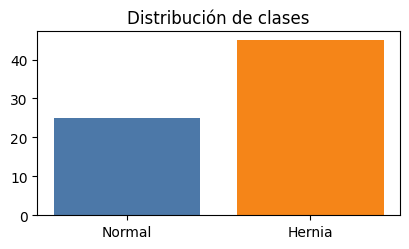

In [27]:
# Etapa 3) Carga de datos y distribución de clases
if USAR_CSV:
    tabla = pd.read_csv(RUTA_CSV).reset_index(drop=True)
    col_ruta = 'image_path' if 'image_path' in tabla.columns else ('path' if 'path' in tabla.columns else 'image')
    col_etiqueta = 'class' if 'class' in tabla.columns else ('label' if 'label' in tabla.columns else 'target')

    muestras = []
    for idx, fila in tabla.iterrows():
        ruta_imagen = Path(str(fila[col_ruta]))
        if not ruta_imagen.is_absolute():
            ruta_imagen = RAIZ / ruta_imagen

        etiqueta_txt = str(fila[col_etiqueta]).strip().lower()
        etiqueta = 0 if etiqueta_txt in ETIQUETAS_NORMAL else 1

        ruta_mascara = None
        if USAR_ANOTACIONES:
            ruta_mascara = Path(str(fila[COLUMNA_MASCARA_CSV]))
            if not ruta_mascara.is_absolute():
                ruta_mascara = RAIZ / ruta_mascara

        muestras.append(Muestra(ruta_imagen, etiqueta, f'p{idx+1:04d}', ruta_mascara=ruta_mascara))

    fuente_datos = f'CSV: {RUTA_CSV}'
else:
    pares_ruta_etiqueta = []
    for carpeta_clase in sorted([p for p in RUTA_IMAGENES.iterdir() if p.is_dir()]):
        etiqueta_carpeta = 0 if carpeta_clase.name.strip().lower() in ETIQUETAS_NORMAL else 1
        for ruta_imagen in sorted(carpeta_clase.rglob('*')):
            if ruta_imagen.suffix.lower() in EXTENSIONES_VALIDAS:
                pares_ruta_etiqueta.append((ruta_imagen, etiqueta_carpeta))

    muestras = []
    for idx, (ruta_imagen, etiqueta) in enumerate(pares_ruta_etiqueta):
        ruta_mascara = None
        if USAR_ANOTACIONES:
            ruta_mascara = RUTA_MASCARAS / ruta_imagen.parent.name / f'{ruta_imagen.stem}_mask.png'
        muestras.append(Muestra(ruta_imagen, etiqueta, f'p{idx+1:04d}', ruta_mascara=ruta_mascara))

    fuente_datos = f'Folder: {RUTA_IMAGENES}'

etiquetas = np.array([m.etiqueta for m in muestras], dtype=int)
ids_paciente = np.array([m.id_paciente for m in muestras])

print('Fuente:', fuente_datos)
print('Total:', len(muestras), '| Normal:', int((etiquetas == 0).sum()), '| Hernia:', int((etiquetas == 1).sum()))
print('Pacientes únicos:', len(np.unique(ids_paciente)))

fig, ax = plt.subplots(figsize=(4.2, 2.6))
ax.bar(['Normal', 'Hernia'], [(etiquetas == 0).sum(), (etiquetas == 1).sum()], color=['#4C78A8', '#F58518'])
ax.set_title('Distribución de clases')
plt.tight_layout()
plt.show()



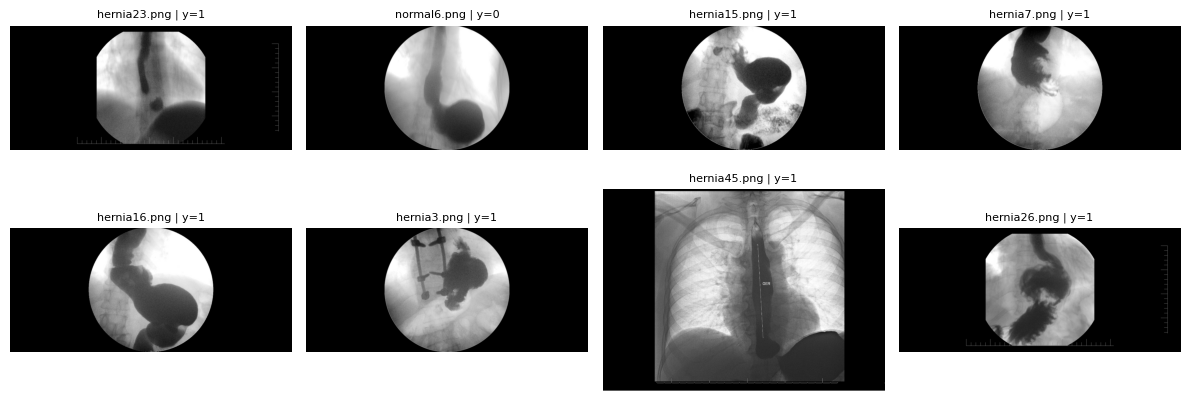

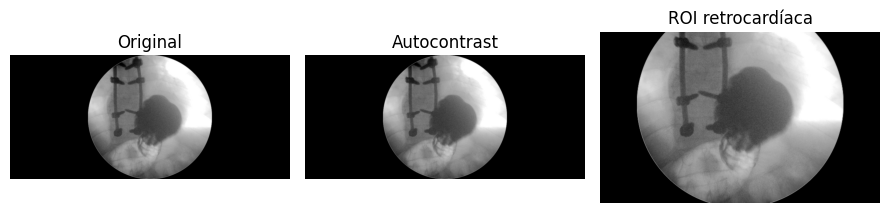

In [28]:
# Etapa 4) Inspección visual y preprocesamiento
indices_muestra = list(range(len(muestras)))
random.Random(SEMILLA).shuffle(indices_muestra)
indices_muestra = indices_muestra[:min(8, len(indices_muestra))]

n_cols = 4
n_rows = int(np.ceil(len(indices_muestra) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.0 * n_cols, 2.2 * n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)

for ax in axes.flat:
    ax.axis('off')

for ax, idx in zip(axes.flat, indices_muestra):
    muestra = muestras[idx]
    with Image.open(muestra.ruta) as imagen:
        ax.imshow(imagen.convert('L'), cmap='gray')
    ax.set_title(f'{muestra.ruta.name} | y={muestra.etiqueta}', fontsize=8)

plt.tight_layout()
plt.show()

# Ejemplo visual de original vs autocontraste vs ROI.
muestra_ejemplo = muestras[0]
with Image.open(muestra_ejemplo.ruta) as imagen:
    imagen_gris = imagen.convert('L')

imagen_auto = ImageOps.autocontrast(imagen_gris)
imagen_roi = RecorteRetrocardiaco()(imagen_gris.convert('RGB')).convert('L')

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for ax, img, titulo in zip(
    axes,
    [imagen_gris, imagen_auto, imagen_roi],
    ['Original', 'Autocontrast', 'ROI retrocardíaca'],
):
    ax.imshow(img, cmap='gray')
    ax.set_title(titulo)
    ax.axis('off')

plt.tight_layout()
plt.show()



In [29]:
# Etapa 5) Split, DataLoaders y lote de verificación
pliegues, nombre_split = construir_pliegues(muestras, n_splits=N_SPLITS, semilla=SEMILLA)
print('Split:', nombre_split)

indices_entrenamiento, indices_validacion = pliegues[0]
print('Fold demo train/val:', len(indices_entrenamiento), len(indices_validacion))

transf_entrenamiento, transf_validacion, transf_visual = construir_transformaciones(
    tam_imagen=TAM_IMAGEN,
    usar_roi=USAR_ROI,
)

dataset_entrenamiento = ConjuntoHiatal(muestras, indices_entrenamiento, transf_entrenamiento)
dataset_validacion = ConjuntoHiatal(muestras, indices_validacion, transf_validacion)

loader_entrenamiento = crear_loader_entrenamiento(
    dataset_entrenamiento,
    muestras,
    indices_entrenamiento,
    tam_batch=TAM_BATCH,
    num_workers=NUM_WORKERS,
    dispositivo=DISPOSITIVO,
    usar_sampler_balanceado=USAR_SAMPLER_BALANCEADO,
)
loader_validacion = DataLoader(
    dataset_validacion,
    batch_size=TAM_BATCH,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DISPOSITIVO.type == 'cuda'),
)

lote_x, lote_y, _ = next(iter(loader_entrenamiento))
print('Batch:', tuple(lote_x.shape), tuple(lote_y.shape))



Split: StratifiedKFold
Fold demo train/val: 56 14
Batch: (8, 3, 320, 320) (8,)


In [30]:
# Etapa 6) Entrenamiento (fold demo)
modelo = crear_modelo(preentrenado=USAR_PREENTRENADO).to(DISPOSITIVO)
if EPOCAS_CONGELADAS > 0:
    fijar_backbone_entrenable(modelo, False)

optimizador = torch.optim.AdamW(
    [
        {'params': modelo.features.parameters(), 'lr': 1e-4},
        {'params': modelo.classifier.parameters(), 'lr': 1e-3},
    ],
    weight_decay=1e-4,
)
planificador = torch.optim.lr_scheduler.CosineAnnealingLR(optimizador, T_max=max(1, EPOCAS))

peso_positivo = calcular_peso_positivo(muestras, indices_entrenamiento, DISPOSITIVO)
if USAR_FOCAL_LOSS:
    criterio = PerdidaFocalBinariaConLogits(gamma=GAMMA_FOCAL, pos_weight=peso_positivo)
else:
    criterio = nn.BCEWithLogitsLoss(pos_weight=peso_positivo)

escalador = crear_escalador_amp(DISPOSITIVO, USAR_AMP)

historial = []
mejor = None
epocas_sin_mejora = 0

for epoca in range(1, EPOCAS + 1):
    if EPOCAS_CONGELADAS > 0 and epoca == EPOCAS_CONGELADAS + 1:
        fijar_backbone_entrenable(modelo, True)

    perdida_train, _, _ = ejecutar_epoca(modelo, loader_entrenamiento, criterio, DISPOSITIVO, optimizador=optimizador, escalador_amp=escalador)
    perdida_val, _, _ = ejecutar_epoca(modelo, loader_validacion, criterio, DISPOSITIVO, optimizador=None, escalador_amp=None)
    y_val, p_val, _ = predecir_loader(modelo, loader_validacion, DISPOSITIVO, usar_tta_flip=USAR_TTA_FLIP_HORIZONTAL)

    umbral = buscar_umbral_optimo(y_val, p_val) if OPTIMIZAR_UMBRAL else 0.5
    metricas = calcular_metricas(y_val, p_val, umbral=umbral)

    fila = {
        'epoca': epoca,
        'perdida_train': float(perdida_train),
        'perdida_val': float(perdida_val),
        'auc': float(metricas['auc']),
        'f1': float(metricas['f1']),
        'sensibilidad': float(metricas['sensibilidad']),
        'especificidad': float(metricas['especificidad']),
        'umbral': float(umbral),
    }
    historial.append(fila)

    score = 0.6 * fila['auc'] + 0.4 * fila['f1']
    if mejor is None or score > mejor['score']:
        mejor = {
            'score': float(score),
            'state_dict': {k: v.detach().cpu().clone() for k, v in modelo.state_dict().items()},
            'metricas': dict(fila),
        }
        epocas_sin_mejora = 0
    else:
        epocas_sin_mejora += 1

    planificador.step()

    print(
        f"Ep {epoca:02d} | train={perdida_train:.4f} val={perdida_val:.4f} "
        f"auc={fila['auc']:.4f} f1={fila['f1']:.4f} "
        f"sens={fila['sensibilidad']:.4f} esp={fila['especificidad']:.4f} "
        f"thr={fila['umbral']:.3f} score={score:.4f}"
    )

    if epocas_sin_mejora >= PACIENCIA:
        print(f'Early stopping en época {epoca}')
        break

print('Mejor época:', mejor['metricas'])



Ep 01 | train=0.1791 val=0.2689 auc=0.5778 f1=0.8421 sens=0.8889 esp=0.6000 thr=0.224 score=0.6835
Ep 02 | train=0.1359 val=0.1365 auc=0.6000 f1=0.8421 sens=0.8889 esp=0.6000 thr=0.392 score=0.6968
Ep 03 | train=0.1735 val=0.2248 auc=0.6222 f1=0.8421 sens=0.8889 esp=0.6000 thr=0.240 score=0.7102
Ep 04 | train=0.1415 val=0.1597 auc=0.7111 f1=0.8571 sens=1.0000 esp=0.4000 thr=0.265 score=0.7695
Ep 05 | train=0.1088 val=0.0906 auc=0.8444 f1=0.9000 sens=1.0000 esp=0.6000 thr=0.393 score=0.8667
Ep 06 | train=0.0747 val=0.0780 auc=0.9111 f1=0.8750 sens=0.7778 esp=1.0000 thr=0.461 score=0.8967
Ep 07 | train=0.0661 val=0.1023 auc=0.9111 f1=0.9474 sens=1.0000 esp=0.8000 thr=0.291 score=0.9256
Ep 08 | train=0.0762 val=0.0808 auc=0.8667 f1=0.9474 sens=1.0000 esp=0.8000 thr=0.392 score=0.8989
Ep 09 | train=0.0340 val=0.0619 auc=0.9111 f1=0.9474 sens=1.0000 esp=0.8000 thr=0.425 score=0.9256
Ep 10 | train=0.0328 val=0.0501 auc=0.9333 f1=0.9474 sens=1.0000 esp=0.8000 thr=0.470 score=0.9389
Ep 11 | tr

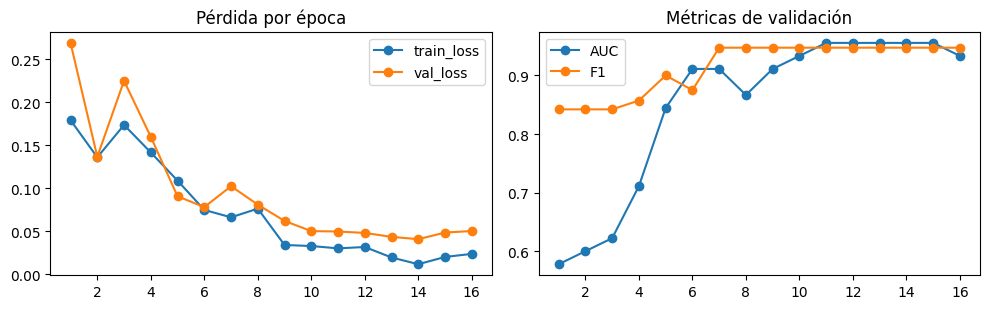

In [31]:
# Etapa 7) Curvas de entrenamiento
epocas = [h['epoca'] for h in historial]
perd_train = [h['perdida_train'] for h in historial]
perd_val = [h['perdida_val'] for h in historial]
auc_hist = [h['auc'] for h in historial]
f1_hist = [h['f1'] for h in historial]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.2))
axes[0].plot(epocas, perd_train, marker='o', label='train_loss')
axes[0].plot(epocas, perd_val, marker='o', label='val_loss')
axes[0].set_title('Pérdida por época')
axes[0].legend()

axes[1].plot(epocas, auc_hist, marker='o', label='AUC')
axes[1].plot(epocas, f1_hist, marker='o', label='F1')
axes[1].set_title('Métricas de validación')
axes[1].legend()

plt.tight_layout()
plt.show()



Métricas fold demo:
- auc: 0.9555555555555556
- accuracy: 0.9285714285714286
- f1: 0.9473684210526315
- sensibilidad: 1.0
- especificidad: 0.8
- tp: 9
- tn: 4
- fp: 1
- fn: 0
- umbral: 0.419015496969223
Guardado: G:\My Drive\Educacion\U de los Andes\MAIA\IV\Proyecto - Desarrollo de Soluciones\maia_proyecto_desarrollo_soluciones\outputs\hiatal_notebook\val_predictions_demo.csv


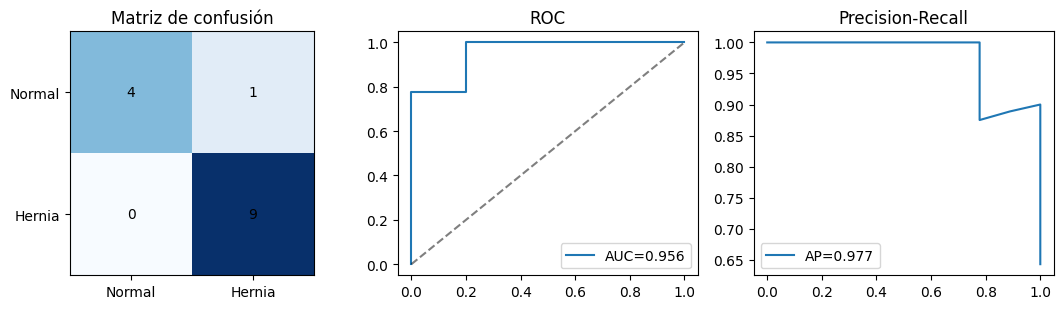

In [32]:
# Etapa 8) Evaluación del fold demo + guardado CSV
modelo.load_state_dict(mejor['state_dict'])
modelo.to(DISPOSITIVO)
modelo.eval()

umbral_demo = float(mejor['metricas']['umbral'])
y_real_demo, p_demo, rutas_demo = predecir_loader(modelo, loader_validacion, DISPOSITIVO, usar_tta_flip=USAR_TTA_FLIP_HORIZONTAL)
y_pred_demo = (p_demo >= umbral_demo).astype(int)

metricas_demo = calcular_metricas(y_real_demo, p_demo, umbral=umbral_demo)
print('Métricas fold demo:')
for clave in ['auc', 'accuracy', 'f1', 'sensibilidad', 'especificidad', 'tp', 'tn', 'fp', 'fn', 'umbral']:
    print(f'- {clave}: {metricas_demo[clave]}')

pred_df = pd.DataFrame({
    'image_path': rutas_demo,
    'y_true': y_real_demo,
    'y_pred': y_pred_demo,
    'probability': p_demo,
    'threshold': umbral_demo,
})
pred_df['correct'] = (pred_df['y_true'] == pred_df['y_pred']).astype(int)
ruta_pred = RUTA_SALIDA / 'val_predictions_demo.csv'
pred_df.to_csv(ruta_pred, index=False)
print('Guardado:', ruta_pred)

matriz = confusion_matrix(y_real_demo, y_pred_demo, labels=[0, 1])
fig, axes = plt.subplots(1, 3, figsize=(11, 3.2))

ax = axes[0]
ax.imshow(matriz, cmap='Blues')
ax.set_title('Matriz de confusión')
ax.set_xticks([0, 1], ['Normal', 'Hernia'])
ax.set_yticks([0, 1], ['Normal', 'Hernia'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(matriz[i, j]), ha='center', va='center')

ax = axes[1]
fpr, tpr, _ = roc_curve(y_real_demo, p_demo)
ax.plot(fpr, tpr, label=f"AUC={auc(fpr, tpr):.3f}")
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.legend(loc='lower right')
ax.set_title('ROC')

ax = axes[2]
precision, recall, _ = precision_recall_curve(y_real_demo, p_demo)
ap = average_precision_score(y_real_demo, p_demo)
ax.plot(recall, precision, label=f"AP={ap:.3f}")
ax.legend(loc='lower left')
ax.set_title('Precision-Recall')

plt.tight_layout()
plt.show()



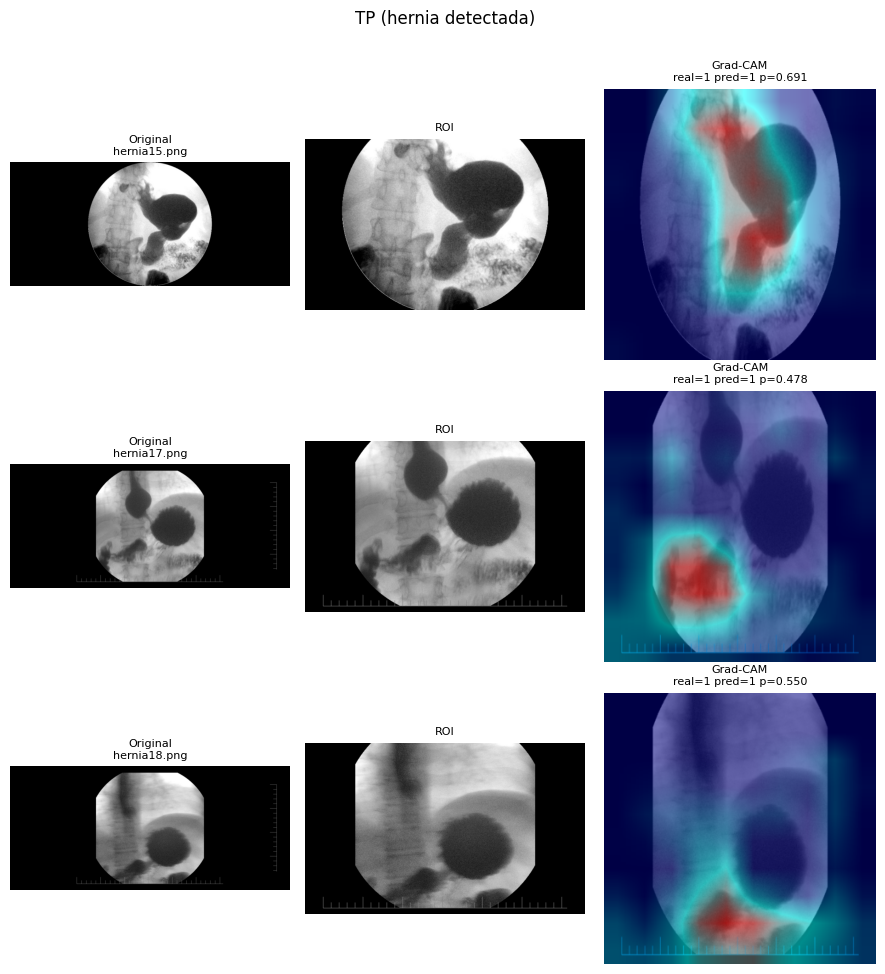

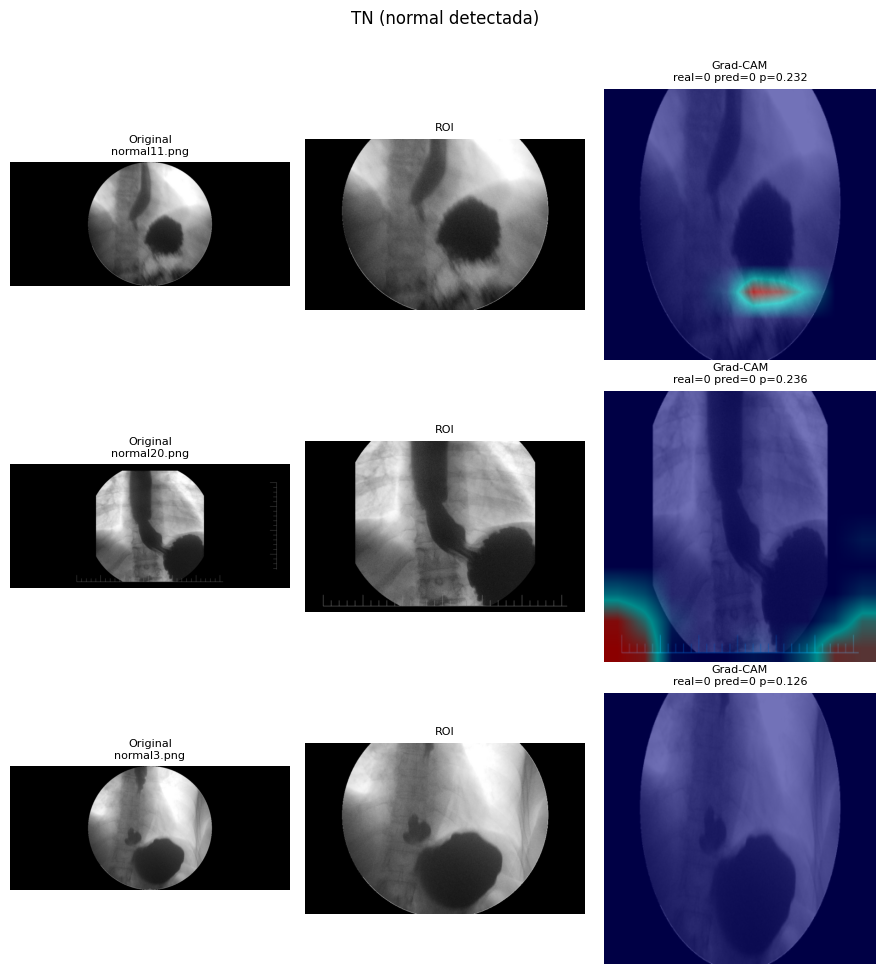

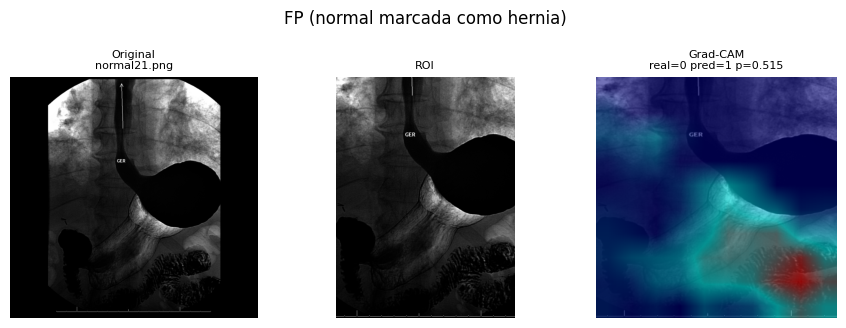

FN (hernia no detectada): sin casos
Grad-CAM guardado en: G:\My Drive\Educacion\U de los Andes\MAIA\IV\Proyecto - Desarrollo de Soluciones\maia_proyecto_desarrollo_soluciones\outputs\hiatal_notebook\gradcam_preview


In [33]:
# Etapa 9) Interpretabilidad con Grad-CAM (TP/TN/FP/FN)
ruta_gradcam = RUTA_SALIDA / 'gradcam_preview'
ruta_gradcam.mkdir(parents=True, exist_ok=True)

# Construir overlay Grad-CAM para una imagen RGB.
def superponer_gradcam(imagen_rgb, modelo, transf_val, transf_vis):
    motor_cam = GradCAMHiatal(modelo, modelo.features.norm5)
    tensor = transf_val(imagen_rgb).unsqueeze(0).to(DISPOSITIVO)
    cam, prob = motor_cam(tensor)
    motor_cam.cerrar()

    cam_np = cam.squeeze(0).cpu().numpy()
    vis = transf_vis(imagen_rgb)
    base = np.asarray(vis, dtype=np.float32) / 255.0
    if base.ndim == 2:
        base = np.stack([base] * 3, axis=-1)

    mapa = Image.fromarray((cam_np * 255).astype(np.uint8))
    mapa = mapa.resize((base.shape[1], base.shape[0]), resample=Image.Resampling.BILINEAR)
    mapa = ImageOps.colorize(mapa, black='#00007F', mid='#00FFFF', white='#FF0000')
    mapa_np = np.asarray(mapa, dtype=np.float32) / 255.0

    overlay = np.clip(0.45 * base + 0.55 * mapa_np, 0.0, 1.0)
    return overlay, float(prob.item())

indices_tp = np.where((y_real_demo == 1) & (y_pred_demo == 1))[0]
indices_tn = np.where((y_real_demo == 0) & (y_pred_demo == 0))[0]
indices_fp = np.where((y_real_demo == 0) & (y_pred_demo == 1))[0]
indices_fn = np.where((y_real_demo == 1) & (y_pred_demo == 0))[0]

# Mostrar un grupo de casos con original, ROI y Grad-CAM.
def mostrar_grupo_casos(indices, titulo, max_casos=3):
    if len(indices) == 0:
        print(f'{titulo}: sin casos')
        return

    seleccion = indices[:max_casos]
    fig, axes = plt.subplots(len(seleccion), 3, figsize=(9, 3.2 * len(seleccion)))
    axes = np.array(axes).reshape(len(seleccion), 3)

    for fila, idx in enumerate(seleccion):
        ruta = Path(rutas_demo[idx])
        y_real = int(y_real_demo[idx])
        y_pred = int(y_pred_demo[idx])
        prob = float(p_demo[idx])

        with Image.open(ruta) as imagen:
            rgb = imagen.convert('RGB')
            gris = rgb.convert('L')
            roi = RecorteRetrocardiaco()(rgb).convert('L')
            overlay, _ = superponer_gradcam(rgb, modelo, transf_validacion, transf_visual)

        axes[fila, 0].imshow(gris, cmap='gray')
        axes[fila, 0].set_title(f'Original\n{ruta.name}', fontsize=8)
        axes[fila, 0].axis('off')

        axes[fila, 1].imshow(roi, cmap='gray')
        axes[fila, 1].set_title('ROI', fontsize=8)
        axes[fila, 1].axis('off')

        axes[fila, 2].imshow(overlay)
        axes[fila, 2].set_title(f'Grad-CAM\nreal={y_real} pred={y_pred} p={prob:.3f}', fontsize=8)
        axes[fila, 2].axis('off')

        nombre = f"{ruta.stem}_y{y_real}_p{prob:.3f}_pred{y_pred}.png"
        Image.fromarray((overlay * 255).astype(np.uint8)).save(ruta_gradcam / nombre)

    plt.suptitle(titulo, y=1.01)
    plt.tight_layout()
    plt.show()

mostrar_grupo_casos(indices_tp, 'TP (hernia detectada)')
mostrar_grupo_casos(indices_tn, 'TN (normal detectada)')
mostrar_grupo_casos(indices_fp, 'FP (normal marcada como hernia)')
mostrar_grupo_casos(indices_fn, 'FN (hernia no detectada)')

print('Grad-CAM guardado en:', ruta_gradcam)





In [34]:
# Etapa 10) Validación cruzada completa (opcional)
if RUN_CV_COMPLETO:
    pliegues_cv, nombre_split_cv = construir_pliegues(muestras, n_splits=N_SPLITS, semilla=SEMILLA)
    print('CV:', nombre_split_cv, '| folds:', len(pliegues_cv))

    probs_oof = np.zeros(len(muestras), dtype=np.float32)
    metricas_folds = []

    for id_fold, (idx_train, idx_val) in enumerate(pliegues_cv, start=1):
        print(f"\n=== Fold {id_fold:02d}/{len(pliegues_cv)} train={len(idx_train)} val={len(idx_val)} ===")

        transf_train_cv, transf_val_cv, _ = construir_transformaciones(tam_imagen=TAM_IMAGEN, usar_roi=USAR_ROI)
        ds_train_cv = ConjuntoHiatal(muestras, idx_train, transf_train_cv)
        ds_val_cv = ConjuntoHiatal(muestras, idx_val, transf_val_cv)

        loader_train_cv = crear_loader_entrenamiento(
            ds_train_cv,
            muestras,
            idx_train,
            tam_batch=TAM_BATCH,
            num_workers=NUM_WORKERS,
            dispositivo=DISPOSITIVO,
            usar_sampler_balanceado=USAR_SAMPLER_BALANCEADO,
        )
        loader_val_cv = DataLoader(
            ds_val_cv,
            batch_size=TAM_BATCH,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=(DISPOSITIVO.type == 'cuda'),
        )

        modelo_fold = crear_modelo(preentrenado=USAR_PREENTRENADO).to(DISPOSITIVO)
        if EPOCAS_CONGELADAS > 0:
            fijar_backbone_entrenable(modelo_fold, False)

        optimizador_fold = torch.optim.AdamW(
            [
                {'params': modelo_fold.features.parameters(), 'lr': 1e-4},
                {'params': modelo_fold.classifier.parameters(), 'lr': 1e-3},
            ],
            weight_decay=1e-4,
        )
        planificador_fold = torch.optim.lr_scheduler.CosineAnnealingLR(optimizador_fold, T_max=max(1, EPOCAS))

        peso_pos_fold = calcular_peso_positivo(muestras, idx_train, DISPOSITIVO)
        if USAR_FOCAL_LOSS:
            criterio_fold = PerdidaFocalBinariaConLogits(gamma=GAMMA_FOCAL, pos_weight=peso_pos_fold)
        else:
            criterio_fold = nn.BCEWithLogitsLoss(pos_weight=peso_pos_fold)

        escalador_fold = crear_escalador_amp(DISPOSITIVO, USAR_AMP)

        mejor_fold = None
        sin_mejora_fold = 0

        for epoca in range(1, EPOCAS + 1):
            if EPOCAS_CONGELADAS > 0 and epoca == EPOCAS_CONGELADAS + 1:
                fijar_backbone_entrenable(modelo_fold, True)

            ejecutar_epoca(modelo_fold, loader_train_cv, criterio_fold, DISPOSITIVO, optimizador=optimizador_fold, escalador_amp=escalador_fold)
            ejecutar_epoca(modelo_fold, loader_val_cv, criterio_fold, DISPOSITIVO, optimizador=None, escalador_amp=None)

            y_val_fold, p_val_fold, _ = predecir_loader(modelo_fold, loader_val_cv, DISPOSITIVO, usar_tta_flip=USAR_TTA_FLIP_HORIZONTAL)
            umbral_fold = buscar_umbral_optimo(y_val_fold, p_val_fold) if OPTIMIZAR_UMBRAL else 0.5
            metricas_fold = calcular_metricas(y_val_fold, p_val_fold, umbral=umbral_fold)
            score_fold = 0.6 * metricas_fold['auc'] + 0.4 * metricas_fold['f1']

            if mejor_fold is None or score_fold > mejor_fold['score']:
                mejor_fold = {
                    'score': float(score_fold),
                    'state_dict': {k: v.detach().cpu().clone() for k, v in modelo_fold.state_dict().items()},
                    'umbral': float(umbral_fold),
                    'epoca': epoca,
                }
                sin_mejora_fold = 0
            else:
                sin_mejora_fold += 1

            planificador_fold.step()
            if sin_mejora_fold >= PACIENCIA:
                break

        modelo_fold.load_state_dict(mejor_fold['state_dict'])
        y_val_fold, p_val_fold, _ = predecir_loader(modelo_fold, loader_val_cv, DISPOSITIVO, usar_tta_flip=USAR_TTA_FLIP_HORIZONTAL)
        resultado_fold = calcular_metricas(y_val_fold, p_val_fold, umbral=mejor_fold['umbral'])
        resultado_fold['fold'] = id_fold
        resultado_fold['best_epoch'] = int(mejor_fold['epoca'])
        resultado_fold['best_threshold'] = float(mejor_fold['umbral'])
        metricas_folds.append(resultado_fold)

        probs_oof[idx_val] = p_val_fold.astype(np.float32)

    y_global = np.array([m.etiqueta for m in muestras], dtype=int)
    umbral_global = buscar_umbral_optimo(y_global, probs_oof) if OPTIMIZAR_UMBRAL else 0.5
    metricas_oof = calcular_metricas(y_global, probs_oof, umbral=umbral_global)

    resumen_cv = {}
    for nombre_metrica in ['auc', 'accuracy', 'f1', 'sensibilidad', 'especificidad']:
        valores = [float(m[nombre_metrica]) for m in metricas_folds]
        resumen_cv[f'{nombre_metrica}_mean'] = float(np.mean(valores))
        resumen_cv[f'{nombre_metrica}_std'] = float(np.std(valores))

    df_oof = pd.DataFrame({
        'image_path': [str(m.ruta) for m in muestras],
        'patient_id': [m.id_paciente for m in muestras],
        'label': [m.etiqueta for m in muestras],
        'probability': probs_oof,
    })
    df_oof['prediction'] = (df_oof['probability'] >= umbral_global).astype(int)
    df_oof.to_csv(RUTA_SALIDA / 'oof_predictions.csv', index=False)

    resumen = {
        'data_source': fuente_datos,
        'num_samples': int(len(muestras)),
        'num_normal': int((etiquetas == 0).sum()),
        'num_hiatal_hernia': int((etiquetas == 1).sum()),
        'device': str(DISPOSITIVO),
        'split_strategy': nombre_split_cv,
        'fold_metrics': metricas_folds,
        'cv_summary': resumen_cv,
        'oof_metrics': metricas_oof,
        'global_threshold': float(umbral_global),
        'weighted_sampler': bool(USAR_SAMPLER_BALANCEADO),
        'focal_loss': bool(USAR_FOCAL_LOSS),
        'tta_hflip': bool(USAR_TTA_FLIP_HORIZONTAL),
    }
    (RUTA_SALIDA / 'metrics_summary.json').write_text(json.dumps(resumen, indent=2), encoding='utf-8')

    print('CV summary:', resumen_cv)
    print('OOF metrics:', metricas_oof)
    print('Guardado en:', RUTA_SALIDA)
else:
    print('RUN_CV_COMPLETO=False (no se ejecutó CV completo)')



CV: StratifiedKFold | folds: 5

=== Fold 01/5 train=56 val=14 ===

=== Fold 02/5 train=56 val=14 ===

=== Fold 03/5 train=56 val=14 ===

=== Fold 04/5 train=56 val=14 ===

=== Fold 05/5 train=56 val=14 ===
CV summary: {'auc_mean': 0.9644444444444444, 'auc_std': 0.022662308949301282, 'accuracy_mean': 0.9428571428571428, 'accuracy_std': 0.02857142857142856, 'f1_mean': 0.9541795665634674, 'f1_std': 0.023035387291316756, 'sensibilidad_mean': 0.9333333333333332, 'sensibilidad_std': 0.05443310539518176, 'especificidad_mean': 0.96, 'especificidad_std': 0.07999999999999999}
OOF metrics: {'umbral': 0.43559324741363525, 'auc': 0.9244444444444444, 'accuracy': 0.8428571428571429, 'f1': 0.8674698795180723, 'sensibilidad': 0.8, 'especificidad': 0.92, 'tp': 36, 'tn': 23, 'fp': 2, 'fn': 9}
Guardado en: G:\My Drive\Educacion\U de los Andes\MAIA\IV\Proyecto - Desarrollo de Soluciones\maia_proyecto_desarrollo_soluciones\outputs\hiatal_notebook


## Etapa 11) Lectura clínica rápida

- **Sensibilidad alta**: menos hernias omitidas (menos FN).
- **Especificidad alta**: menos normales marcadas como hernia (menos FP).
- Revisar siempre **FP/FN** con ROI + Grad-CAM para discutir casos límite con especialistas.



Resumen de entrenamiento (fold demo):
- épocas ejecutadas: 16
- mejor época: 11
- train_loss(mejor): 0.0300
- val_loss(mejor): 0.0496
- umbral(mejor): 0.4190

Métricas finales:
              split  n    auc  accuracy     f1  sensibilidad  especificidad  tp  tn  fp  fn
         train_eval 56 1.0000    1.0000 1.0000           1.0            1.0  36  20   0   0
test_eval_fold_demo 14 0.9556    0.9286 0.9474           1.0            0.8   9   4   1   0


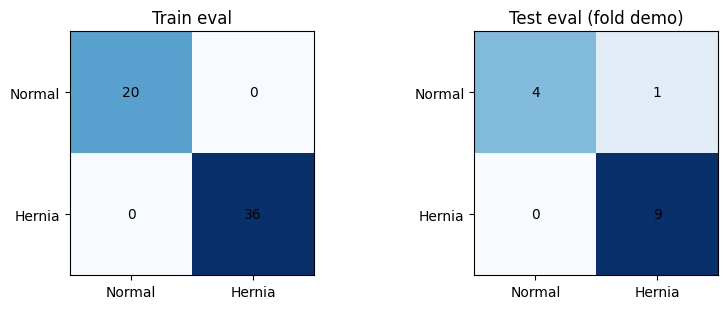

In [35]:
# Etapa 12) Resumen numérico final: entrenamiento vs prueba
umbral_final = float(mejor['metricas']['umbral'])

print('Resumen de entrenamiento (fold demo):')
print(f"- épocas ejecutadas: {len(historial)}")
print(f"- mejor época: {int(mejor['metricas']['epoca'])}")
print(f"- train_loss(mejor): {mejor['metricas']['perdida_train']:.4f}")
print(f"- val_loss(mejor): {mejor['metricas']['perdida_val']:.4f}")
print(f"- umbral(mejor): {umbral_final:.4f}")

ds_train_eval = ConjuntoHiatal(muestras, indices_entrenamiento, transf_validacion)
loader_train_eval = DataLoader(
    ds_train_eval,
    batch_size=TAM_BATCH,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DISPOSITIVO.type == 'cuda'),
)

y_train_eval, p_train_eval, _ = predecir_loader(modelo, loader_train_eval, DISPOSITIVO, usar_tta_flip=USAR_TTA_FLIP_HORIZONTAL)
metricas_train = calcular_metricas(y_train_eval, p_train_eval, umbral=umbral_final)
metricas_test = calcular_metricas(y_real_demo, p_demo, umbral=umbral_final)

resumen_df = pd.DataFrame([
    {
        'split': 'train_eval',
        'n': len(y_train_eval),
        'auc': metricas_train['auc'],
        'accuracy': metricas_train['accuracy'],
        'f1': metricas_train['f1'],
        'sensibilidad': metricas_train['sensibilidad'],
        'especificidad': metricas_train['especificidad'],
        'tp': metricas_train['tp'],
        'tn': metricas_train['tn'],
        'fp': metricas_train['fp'],
        'fn': metricas_train['fn'],
    },
    {
        'split': 'test_eval_fold_demo',
        'n': len(y_real_demo),
        'auc': metricas_test['auc'],
        'accuracy': metricas_test['accuracy'],
        'f1': metricas_test['f1'],
        'sensibilidad': metricas_test['sensibilidad'],
        'especificidad': metricas_test['especificidad'],
        'tp': metricas_test['tp'],
        'tn': metricas_test['tn'],
        'fp': metricas_test['fp'],
        'fn': metricas_test['fn'],
    },
])

print('\nMétricas finales:')
print(resumen_df.round(4).to_string(index=False))

pred_train_eval = (p_train_eval >= umbral_final).astype(int)
pred_test_eval = (p_demo >= umbral_final).astype(int)

cm_train = confusion_matrix(y_train_eval, pred_train_eval, labels=[0, 1])
cm_test = confusion_matrix(y_real_demo, pred_test_eval, labels=[0, 1])

fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.2))
for ax, cm, titulo in [
    (axes[0], cm_train, 'Train eval'),
    (axes[1], cm_test, 'Test eval (fold demo)'),
]:
    ax.imshow(cm, cmap='Blues')
    ax.set_title(titulo)
    ax.set_xticks([0, 1], ['Normal', 'Hernia'])
    ax.set_yticks([0, 1], ['Normal', 'Hernia'])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.tight_layout()
plt.show()




Imagen: G:\My Drive\Educacion\U de los Andes\MAIA\IV\Proyecto - Desarrollo de Soluciones\maia_proyecto_desarrollo_soluciones\data\images\normal\normal1.png
Probabilidad hernia: 0.1154
Umbral: 0.4190
Predicción final: Normal (0)


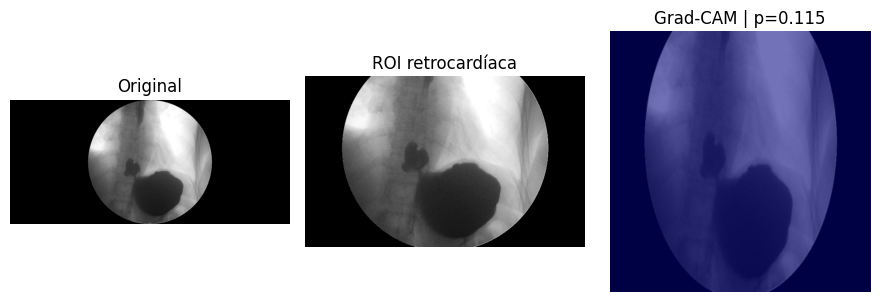

In [36]:
# Etapa 13) Inferencia sobre una imagen nueva
RUTA_NUEVA_IMAGEN = RAIZ / 'data' / 'images' / 'normal' / 'normal1.png'
USAR_TTA_NUEVA_IMAGEN = True
MOSTRAR_GRADCAM_NUEVA_IMAGEN = True

umbral_inferencia = float(mejor['metricas']['umbral'])
ruta = Path(RUTA_NUEVA_IMAGEN)
if not ruta.is_absolute():
    ruta = RAIZ / ruta

with Image.open(ruta) as imagen:
    rgb = imagen.convert('RGB')
    gris = rgb.convert('L')
    roi = RecorteRetrocardiaco()(rgb).convert('L')

    tensor = transf_validacion(rgb).unsqueeze(0).to(DISPOSITIVO)
    modelo.eval()
    with torch.no_grad():
        prob = torch.sigmoid(modelo(tensor))[0, 0]
        if USAR_TTA_NUEVA_IMAGEN:
            tensor_flip = torch.flip(tensor, dims=[3])
            prob_flip = torch.sigmoid(modelo(tensor_flip))[0, 0]
            prob = 0.5 * (prob + prob_flip)

    prob = float(prob.item())
    pred = int(prob >= umbral_inferencia)
    pred_texto = 'Hernia hiatal' if pred == 1 else 'Normal'

    print(f'Imagen: {ruta}')
    print(f'Probabilidad hernia: {prob:.4f}')
    print(f'Umbral: {umbral_inferencia:.4f}')
    print(f'Predicción final: {pred_texto} ({pred})')

    if MOSTRAR_GRADCAM_NUEVA_IMAGEN:
        overlay, _ = superponer_gradcam(rgb, modelo, transf_validacion, transf_visual)
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        axes[0].imshow(gris, cmap='gray')
        axes[0].set_title('Original')
        axes[0].axis('off')

        axes[1].imshow(roi, cmap='gray')
        axes[1].set_title('ROI retrocardíaca')
        axes[1].axis('off')

        axes[2].imshow(overlay)
        axes[2].set_title(f'Grad-CAM | p={prob:.3f}')
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()
    else:
        fig, axes = plt.subplots(1, 2, figsize=(6.5, 3))
        axes[0].imshow(gris, cmap='gray')
        axes[0].set_title('Original')
        axes[0].axis('off')
        axes[1].imshow(roi, cmap='gray')
        axes[1].set_title('ROI retrocardíaca')
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()

